1.   Divyaprabha M
2.   Pratishtha Gaur 
3.   Abhinav Chawla




### Importing the libraries

In [ ]:
# Loading libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import ndimage
import math
import keras
import ast
import operator as op
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Suppressing warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
# Global Variable
# Binary Image Dictionary
dict_clean_img = {} 

# Original Image Dictionary
dict_img = {} 

# Keras support channel first (1,28,28) only
keras.backend.set_image_data_format("channels_first")

In [ ]:
# Loading the trained model
from google.colab import drive
drive.mount('/content/drive')

model = keras.models.load_model('/content/drive/MyDrive/ImageProcModel.h5', compile=False)

Mounted at /content/drive


### Defining all the utility functions

In [ ]:
# Supported Operators
operators = {
    ast.Add: op.add, 
    ast.Sub: op.sub, 
    ast.Mult: op.mul,
    ast.Div: op.truediv, 
    ast.Pow: op.pow, 
    ast.BitXor: op.xor,
    ast.USub: op.neg
}


def eval_expr(expr):
    return eval_(ast.parse(expr, mode='eval').body)


def eval_(node):
    if isinstance(node, ast.Num): 
        return node.n
    elif isinstance(node, ast.BinOp): 
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp):
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)


def sort_contours(cnts, method="left-to-right"):
    # Initialize the reverse flag and sort index
    reverse = False
    i = 0

    # Handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # Handle if we are sorting against the y-coordinate rather than the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # Construct the list of bounding boxes and sort them from top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))

    # Return the tuple of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted


#Data Generator using tensorflow method
train_datagen = ImageDataGenerator(   
    data_format='channels_first',
    zca_whitening = True,
    rotation_range = 0.2
)



def extract_box(img, show=True):
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Otsu thresholding
    thresh, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Defining a kernel length
    kernel_length = np.array(binary_image).shape[1]//80

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(binary_image, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(binary_image, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
    
    # Join horizontal and vertical images
    alpha = 0.5
    beta = 1.0 - alpha
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Find and sort the contours
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    
    area = []
    for contour in contours:
        area.append(cv2.contourArea(contour))
    
    s = np.argsort(area)
    
    workspace_contours = []    
    # Find the correct boxes where area is between 40% and 50% of the largest rectangle
    for i,contour in enumerate(contours):
        if cv2.contourArea(contour) >= area[s[-1]]*0.40  and cv2.contourArea(contour) < area[s[-1]]*0.50:
            workspace_contours.append(contour)
    
    # A list to containing rectangle locs
    rectangle_locs =[]   
    
    # Finding out locations of rectangle
    for cnt in workspace_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rectangle_locs.append([x,y,w,h])        
    
    if (show):
        fig = plt.figure(figsize=(7,9))
        fig.suptitle('Extracted Workspaces')
        i=1
        l = len(rectangle_locs)
        for rect in rectangle_locs:
            ax = fig.add_subplot(l,1,i)
            ax.imshow(img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])
            i = i+1
        plt.show()
        
    return rectangle_locs


def find_good_contours_thres(conts, alpha = 0.002):
    # Calculating areas of contours and appending them to a list
    areas = []
    
    for c in conts:
        areas.append([cv2.contourArea(c)**2])   
    thres = alpha * max(areas)[0]
    
    return thres


def extract_line(image, beta=0.7, alpha=0.002, show = True):
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    
    # Converting image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binary thresholding
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    # Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    
    # Saving a copy of dilated image for taking bitwise_and operation
    temp = dilation.copy()
    
    # Find the contours
    contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    cont_thresh = find_good_contours_thres(contours, alpha=alpha)

    # Creating a mask of only ones    
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    # Drawing those contours which are noises and then taking bitwise and
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    
    # Dilating the cleaned image for better detection of line in cases where exponents are little up the line
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    # Getting back the cleaned original image without noise
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    # Find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    
    # Extending uppers and lowers indexes to avoid cutting of chars of lines
    # Extended more uppers by 33% as exponential might lie above 
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
    # Combining rogue exponentials into their deserving lines. This happens when exponential and lines are separated by some distance
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')

    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    # For changing color of intermediate lines, keeping count
    col_ct = 0
    
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        col1 = (153,255,255)
        col2 = (255,255,153)
        if(col_ct % 2 == 0):
            col= col1
        else: 
            col=col2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        col_ct += 1
        
    if(show == True):
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,3,1)
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,3,2)
        ax2.set_title('Cleaned Image')
        ax2.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2RGB))
        ax2.axis('off')
        
        ax3 = fig0.add_subplot(1,3,3)
        ax3.set_title('Noises')
        ax3.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax3.axis('off')
        
        fig0.suptitle('Denoising')
        plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis("off")
        ax1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax2 = fig1.add_subplot(1,2,2)    
        ax2.axis("off")
        ax2.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]


def text_segment(Y1,Y2,X1,X2,box_num,line_name, dict_clean = dict_clean_img,\
                 acc_thresh = 0.60, show = True):
    img = dict_clean[box_num][Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1

    # Apply some dilation and erosion to join the gaps
    # Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    # Find the contours
    contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    ct_th = find_good_contours_thres(contours, alpha=0.005)
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = sort_contours(cnts,method="left-to-right")
    char_locs = []
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
                x1,y1,w1,h1 = bounding_boxes[i+1]
                if abs(x-x1) < 10 and  (h1+h) < 70:
                    minX = min(x,x1)
                    minY = min(y,y1)
                    maxX = max(x+w, x1+w1)
                    maxY = max(y+h, y1+h1)
                    x,y,x11,y11 = minX, minY, maxX, maxY
                    
                    x,y,w,h = x,y,x11-x,y11-y
                    i = i+2
                    continue
             
            if(h<0.10*L_H and w<0.10*L_H):
                i=i+1
                continue

            char_locs.append([x-2,y+Y1-2,x+w+1,y+h+Y1+1,w*h])
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)

            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i = i+1
            char_type.append(exp)
             
    

    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['pred'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char['pred_proba'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], proba=True, acc_thresh=acc_thresh), axis=1 )
    df_char.apply(lambda c: cv2.putText(img, c['pred'], (c['X1']-10,35), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5,(147,96,247), 3, cv2.LINE_AA), axis=1) 
    df_char['line_name'] = line_name
    df_char['box_num'] = box_num

    if(show == True):        
        plt.figure(figsize=(15,8))   

        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    	  
    return [box_num,line_name,df_char]


def predict(img,x1,y1,x2,y2, proba = False, acc_thresh = 0.60):
    gray = img[y1:y2, x1:x2]

    # Steps to remove noises in image due to cropping
    temp = gray.copy()
    
    kernel_temp = np.ones((3,3), np.uint8) 
    temp_tmp = cv2.dilate(temp, kernel_temp, iterations=3)
    
    # Find the contours -  To check whether its disjoint character or noise
    contours_tmp,hierarchy = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    if(len(contours_tmp) > 1):
        # Find the contours
        contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        # Creating a mask of only zeros  
        mask = np.ones(gray.shape[:2], dtype="uint8") * 0
        # Find the index of the largest contour
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        # Drawing those contours which are noises and then taking bitwise and
        gray = cv2.bitwise_and(temp, temp, mask=mask)
        
    grayN = process_img (gray, resize_flag = 0)
    
    classes = model.predict(grayN, batch_size=2)
    ind = np.argmax(classes)
    c = ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']

    
    if (proba == True):
        return classes[0][ind]
    
    return c[ind]



def process_img(gray, resize_flag = 1, preproc = 0):
    gray = gray.copy()
    
    # Image Pre Processing
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0)
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)    
        gray = cv2.GaussianBlur(gray,(5,5),1)
        gray = cv2.dilate(gray, kernel, iterations=2)
        gray = cv2.erode(gray, kernel,iterations=2)    
    
    # Removing rows and columns where all the pixels are black
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    # Making the aspect ratio same before re-sizing
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    # Padding to a 28 * 28 image
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    
    # Get the best shifts
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    # Normalize the image
    grayS = grayS/255
    
    return grayS



def evaluate(df,A,B,X,Y):
    # Evaluating Expression
    actual = A*X*X+(B*Y)
    
    try:
        pred = df["exp"].apply(lambda d: "**" if d==1 else "")
        pred = "".join(list(pred+df["pred"]))
        
        # Looking for non digits in the start of the string
        matchesN = re.findall('^\-\-', pred)
        if(len(matchesN) > 0):
            for s in matchesN:
                pred = pred.replace(s,'')       
                
            
        # Looking for broken 5's
        matches5 = re.findall(r'5\*\*-\D*', pred)
        if(len(matches5) > 0):
            for s in matches5:
                sn = s.split('5**-')
                snew = sn[0]+'5'+sn[1]
                pred = pred.replace(s,snew)  

        
        # This except block is fired when brackets are unnecessarily used while writing the answerscripts and in strings
        matchesB_left = re.findall(r'\d\(\d', pred)
        matchesB_right = re.findall(r'\d\)\d', pred)
        
        if(len(matchesB_left) > 0 or len(matchesB_right) > 0):
            for s in matchesB_left:
                sn = s.split('(')
                snew = sn[0]+'*('+sn[1]
                pred = pred.replace(s,snew)    
                
            for s in matchesB_right:
                sn = s.split(')')
                snew = sn[0]+')*'+sn[1]
                pred = pred.replace(s,snew) 
        
        ans = eval_expr(pred)
        print(pred )

        if(df['pred_proba'].mean() < 0.75):
            return 5
        
    except Exception as e:
        print(pred,'-',e)
        return 5
    
    return actual==ans

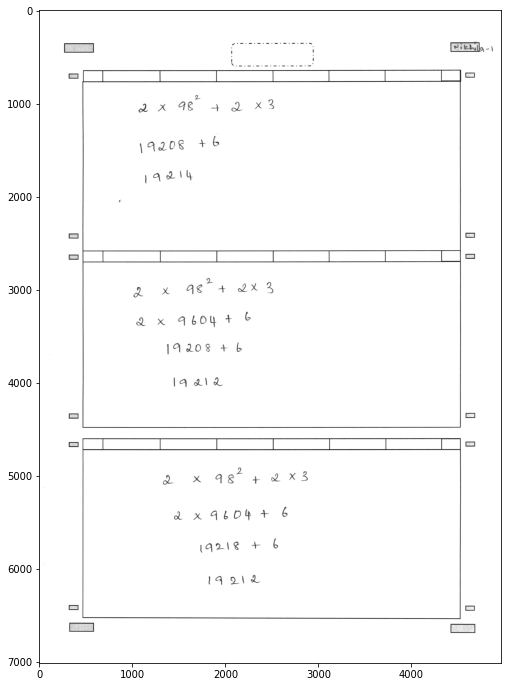

In [ ]:
image_path = "image_13.jpg"
A = 2
B = 2
X = 98
Y = 3

img = cv2.imread(image_path)
plt.figure(figsize=(12,12))
plt.imshow(img)

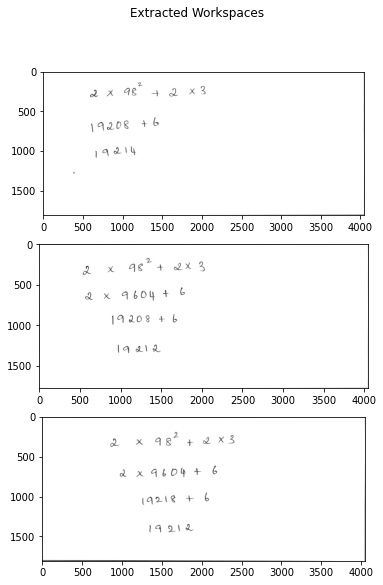

In [ ]:
# Workspaces Detection
workspaces = extract_box(img)

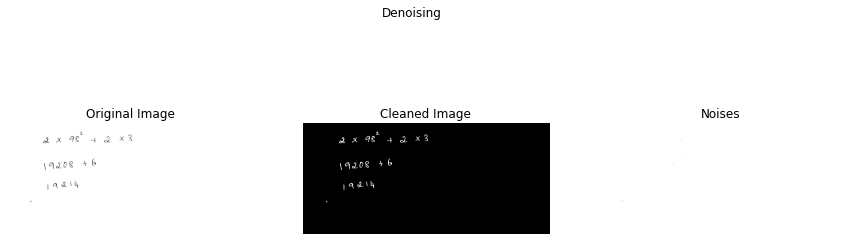

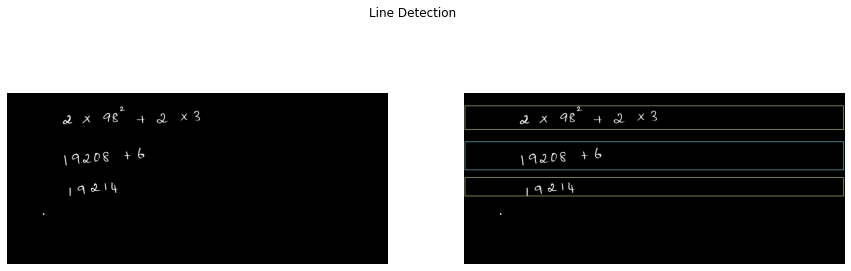

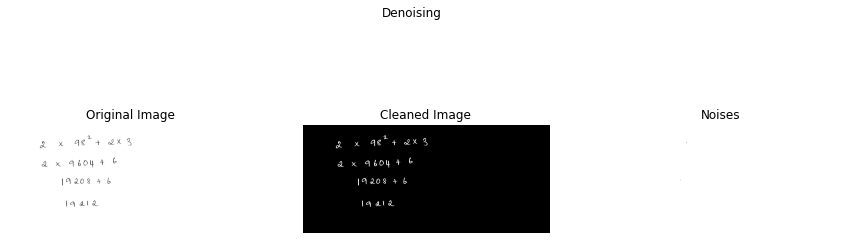

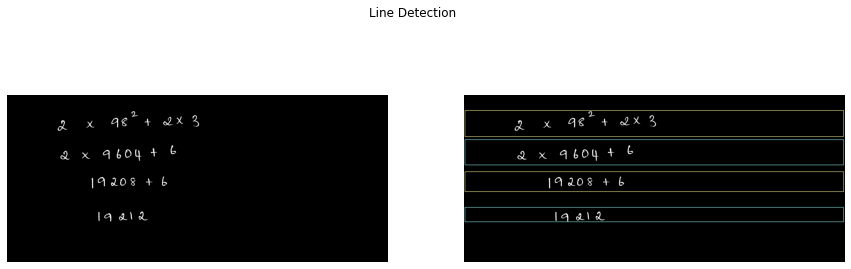

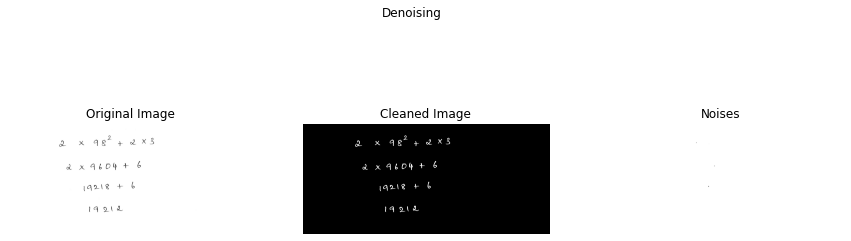

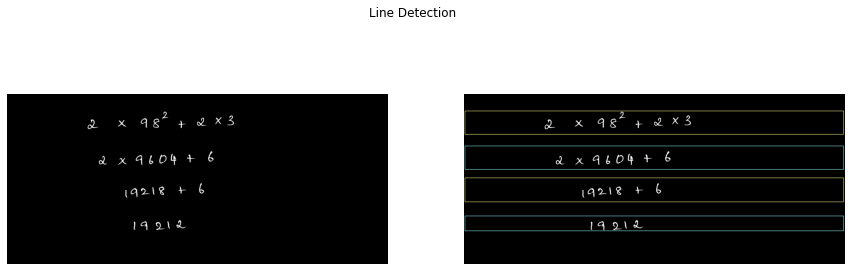

In [ ]:
# Defining dataframe for storing information about every line detected
df_lines = pd.DataFrame()

for r,rect in enumerate(workspaces):
    # Cropping boxes for sending to line detection module
    box = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
    H,W = box.shape[:2]
    # Extracting lines present in the boxes
    cleaned_orig,y1s,y2s = extract_line(box, show=True)
    x1s = [0]*len(y1s)
    x2s = [W]*len(y1s)
    
    df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
    df.columns = ['y1','y2','x1','x2']
    df['box_num'] = r

    df_lines= pd.concat([df_lines, df])

    dict_clean_img.update({r:cleaned_orig})
    dict_img.update({r:box})


df_lines['line_name'] = ['%d%d' %(df_lines.box_num.iloc[i],df_lines.index[i]) for i in range(len(df_lines))]

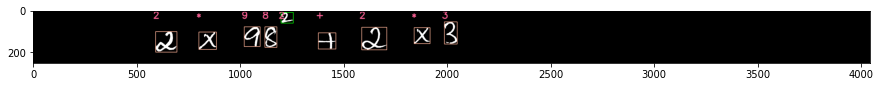

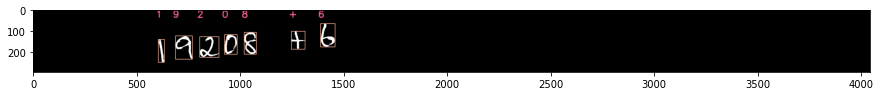

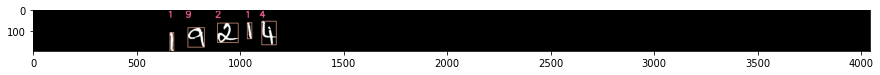

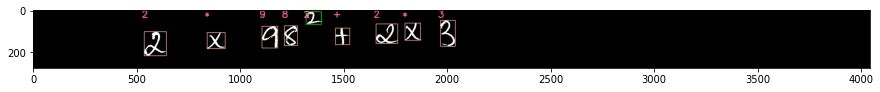

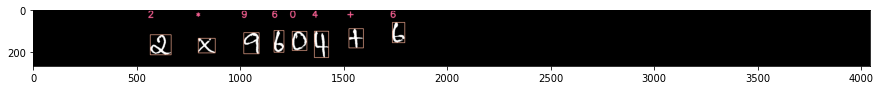

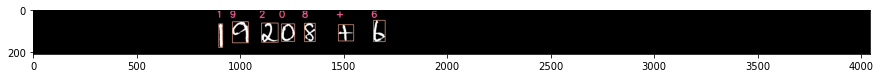

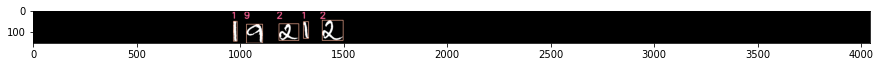

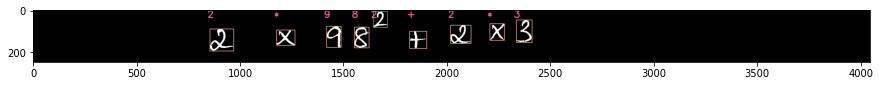

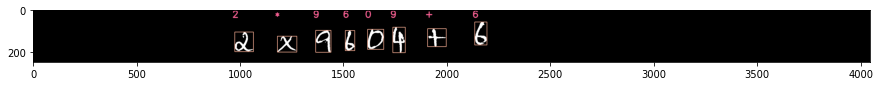

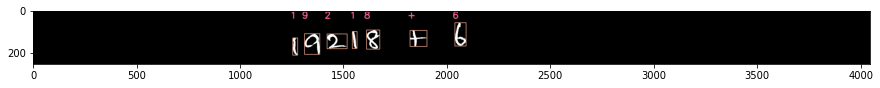

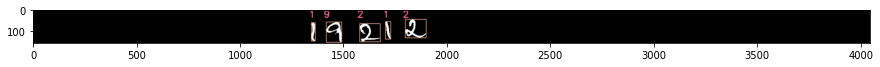

In [ ]:
# df_chars contains locations of all characters along with box_num and line name
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],row['x1'],row['x2'],
                                                          row['box_num'],row['line_name'], 
                                                          show=True), axis=1))


BOX 1
2*98**2+2*3
19208+6
19214

BOX 2
2*98**2+2*3
2*9604+6
19208+6
19212

BOX 3
2*98**2+2*3
2*9609+6
19218+6
19212


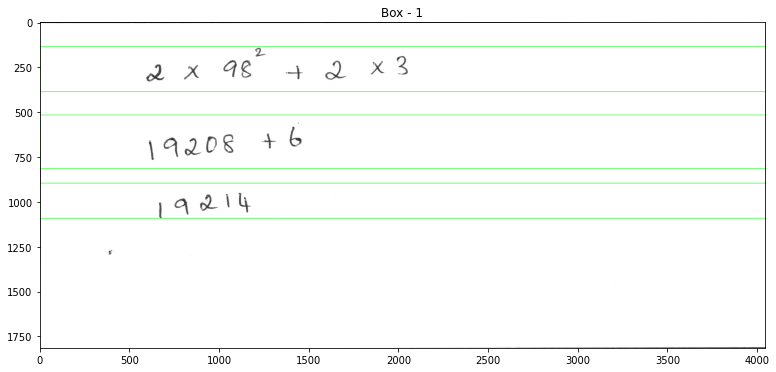

<Figure size 432x288 with 0 Axes>

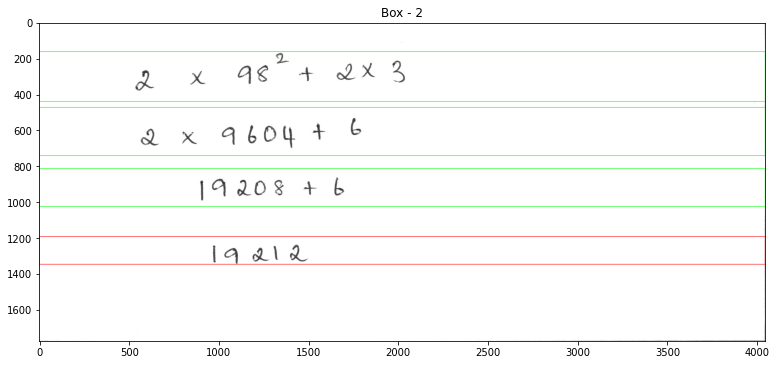

<Figure size 432x288 with 0 Axes>

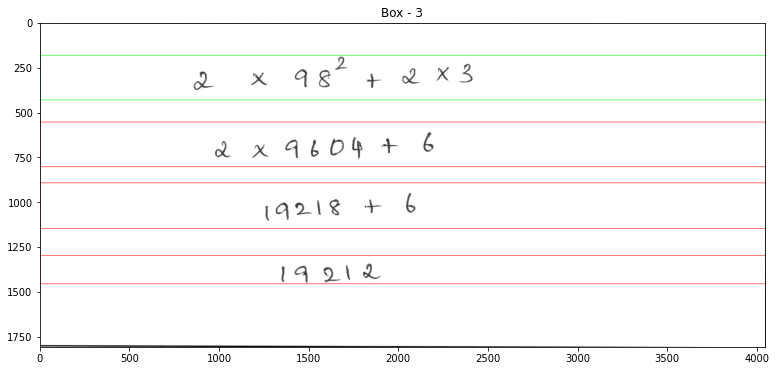

<Figure size 432x288 with 0 Axes>

In [ ]:
df_chars = pd.DataFrame(list_chars)
df_chars.columns = ['box_num', 'line_name', 'char_df']
    
box_nums = df_chars.box_num.unique()
char_area_list = []
df_chars['char_df'].apply(lambda d: char_area_list.append(list(d['area'])) )

# Area based threshold for detecting and removing noises
gamma = 0
max_ar = max([max(i) for i in char_area_list])
ar_thresh = max_ar*gamma

# Keeping only those characters whose area of contours is above area threshold
df_chars['char_df'] = df_chars['char_df'].apply(lambda d: d[d.area > ar_thresh] )

for bn in box_nums:
    print('\nBOX %d' %(bn+1))
    box_img = dict_clean_img[bn]
    box_img_1 = dict_img[bn] 
    box_img = cv2.cvtColor(box_img, cv2.COLOR_GRAY2BGR)
    
    df = df_chars[df_chars.box_num == bn].copy()
    df_l = df_lines[df_lines["box_num"]==bn].copy()
    
    df['char_df'].apply(lambda d: d.apply(lambda c: cv2.rectangle(box_img, \
      (c['X1'],c['Y1']),(c['X2'], c['Y2']),(255*(c['exp']==1),180,0),2+(2*c['exp'])), axis=1 ) )
    
    df['line_status'] = df['char_df'].apply(lambda d: evaluate(d[["pred","exp","pred_proba"]],A,B,X,Y))
    
    scale_percent = 200 
    width = int(box_img.shape[1] * scale_percent / 100)
    height = int(box_img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    box_img = cv2.resize(box_img, dim, interpolation = cv2.INTER_AREA)

    # Drawing rectangle on original Image
    df_l['line_status'] = list(df['line_status']) 
    df_l.apply(lambda c: cv2.rectangle(box_img_1, (c['x1'],c['y1']),(c['x2'],c['y2']),
                                       (255*(c['line_status']==5),255*(c['line_status']==True), 
                                        255*(c['line_status']==False)),2), axis=1)
    
    plt.figure(figsize=(13,7))
    plt.title('Box - %d' %(bn+1) )
    plt.imshow(cv2.cvtColor(box_img_1, cv2.COLOR_BGR2RGB))
    plt.figure()